In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
np.set_printoptions(precision=4)

In [2]:
frame_dir = '../data/frames/'
n_cam = 4

# cam_dir = [glob.glob(frame_dir+'camera1/*jpg')]
cam_dir = []
for i in range(1,n_cam+1):
    cam_dir.append(glob.glob(frame_dir+'camera'+str(i)+"/*.jpg"))
    cam_dir[i-1].sort()

# [x y z roll pitch yaw]
cam_poses = np.array([
    [20, 20, 12, 0, 0, -2.2],
    [20, -15, 12, 0, 0, 2.2],
    [-20, -20, 12, 0, 0, 0.7],
    [-20, 20, 12, 0, 0, -0.7],
])

# 321 Euler sequence
def euler2dcm(euler):
    from numpy import sin,cos,tan
    phi = euler[0]
    theta = euler[1]
    psi = euler[2]
    
    dcm = np.array([
        [cos(theta)*cos(psi), cos(theta)*sin(psi), -sin(theta)],
        [-cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi), cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(theta)],
        [sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi), -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi), cos(phi)*cos(theta)]
    ])
    return dcm

def cart2hom(point):
    return np.hstack([point,1.0])

def hom2cart(coord):
    return coord[0:-1]

from mpl_toolkits.mplot3d import Axes3D
Multiple View Geometry, Chapter 6, p156 
$$x_{pixel} = P X_{world}$$
$$P = K[R|t] $$

$$ t = -R\tilde{C}$$

$$K = \begin{bmatrix}
f_x & s & c_x\\
    & f_y & c_y\\
    & & 1
\end{bmatrix}
$$

"$R$ is the rotation matrix representing the orientation of the camera coordinate frame, $\tilde{C}$ is the camera's postion in the world frame".

Another Rotation to consider is from the camera model frame used in gazebo to conventional camera frame used in literature.

$$
\begin{bmatrix}
0 & 1 & 0\\
0 & 0 & 1\\
-1 & 0 & 0
\end{bmatrix}
$$

From gazebo camera_info:

D: [0.0, 0.0, 0.0, 0.0, 0.0]

K: [642.0926159343306, 0.0, 1000.5, 0.0, 642.0926159343306, 1000.5, 0.0, 0.0, 1.0]

R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

P: [642.0926159343306, 0.0, 1000.5, -44.94648311540315, 0.0, 642.0926159343306, 1000.5, 0.0, 0.0, 0.0, 1.0, 0.0]

In [3]:
def get_cam_in(cam_param):
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    cam_in = np.array([
        [fx, s, cx],
        [0, fy, cy],
        [0, 0, 1],
    ])
    return cam_in

def get_cam_ex(cam_att):
    rot_world2model = euler2dcm(cam_att)
    rot_model2cam = - np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ])
    
    cam_ex = rot_model2cam @ rot_world2model
    return cam_ex
    
def get_cam_mat(cam_param, cam_pose):
    assert(len(cam_param)==5 and len(cam_pose)==6)
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    
    pos = cam_pose[0:3]
    euler = cam_pose[3:6]
    
    # intrinsic matrix
    cam_in = np.array([
        [fx, s, cx],
        [0, fy, cy],
        [0, 0, 1],
    ])
    
    # extrinsic matrix
    rot_world2model = euler2dcm(euler)
    rot_model2cam = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ])
    
    cam_ex = rot_model2cam @ rot_world2model
    cam_mat = cam_in @ np.block([cam_ex, -(cam_ex @ pos).reshape(-1,1)])
    return cam_mat

(2000.0, 0.0)

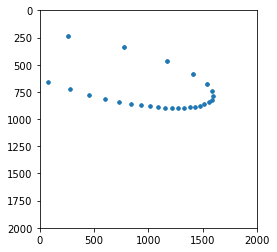

In [4]:
cam = 0

cam_param = [642.0926, 642.0926, 1000.5, 1000.5,0]
cam_mat = get_cam_mat(cam_param, cam_poses[cam])
# n_frames = min([len(cam_dir[i]) for i in range(n_cam)])
n_frames = len(cam_dir[cam])

drone_coords = []
for i in range(n_frames):
    elapsed = i*0.1
    x = 30*np.sin(2*np.pi*elapsed*1/3)
    y = 15*np.cos(2*np.pi*elapsed*1/3)
    z = 20
    drone_coords.append([x,y,z])
drone_coords = np.array(drone_coords)

drone_coords_hom = np.hstack([drone_coords, np.ones((n_frames,1))])

pixel_coords_hom = (cam_mat @ drone_coords_hom.T).T

pixel_coords = []
for coord in pixel_coords_hom:
    pixel_coords.append([coord[0]/coord[2], coord[1]/coord[2]])
pixel_coords = np.array(pixel_coords)

fig = plt.figure()
plt.plot(pixel_coords[:,0], pixel_coords[:,1], '.')
plt.axis('square')
plt.xlim(0,2000)
plt.ylim(2000,0)

In [7]:
def draw_box(img, coords):
#     p_h = cam_mat@cart2hom(drone_pos)
#     p_h = p_h/p_h[-1]

#     p = hom2cart(p_h)
    box_size = 10
    color = (255,255,0)
    for row in coords:
        start = (row - [box_size, box_size]).astype(np.int32)
        end = (row + [box_size, box_size]).astype(np.int32)

        thickness = 1
        img = cv.rectangle(img, start, end, color, thickness)

    return img

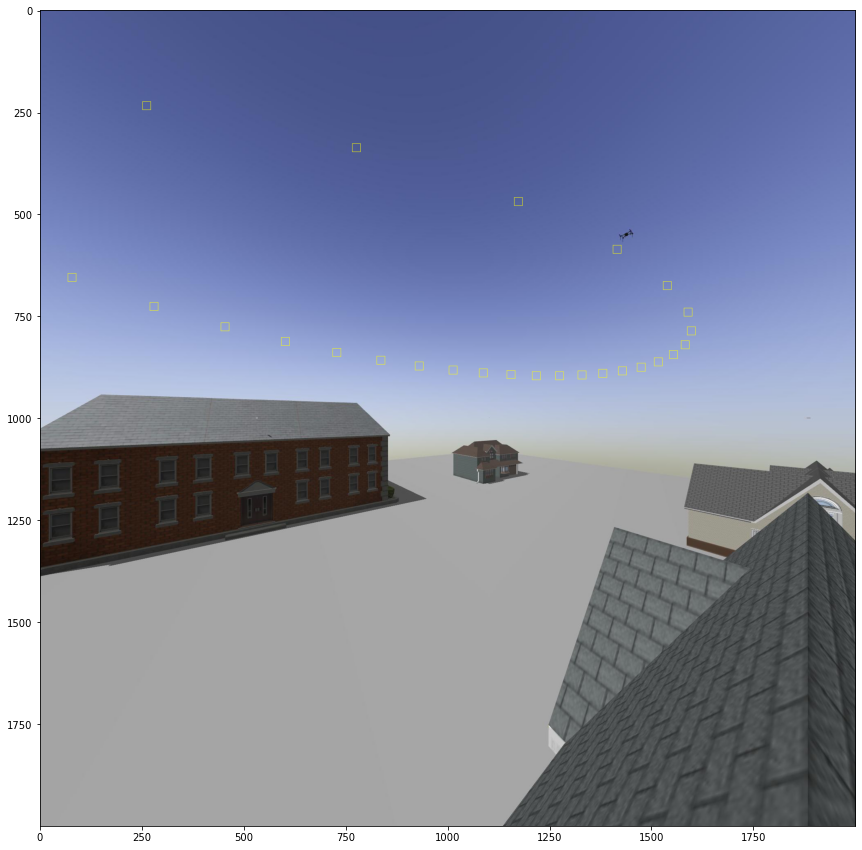

In [8]:
cam_imgs = cam_dir[cam]
plt.figure(figsize=(15,15))
img = plt.imread(cam_imgs[1])
img_detect = draw_box(img, pixel_coords)
plt.imshow(img_detect)

In [ ]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(15,15))

ims = []
cam_imgs = cam_dir[cam]
for i in range(n_frames):
    plt.figure(figsize=(15,15))
    img = plt.imread(cam_imgs[i])
    img_detect = draw_box(img, pixel_coords)
    im = ax.imshow(img_detect);
    ims.append([im])

ani = ArtistAnimation(fig, ims, interval=100)
HTML(ani.to_html5_video())

# Calibration
Calibrate camera 4 with using the other camera's location <br>
Known: Cameras' positions (pos), cameras' pixel coords (from reprojection) <br>
Optimize: Camera's orientation (euler) <br>

In [9]:
import casadi as ca

def euler2dcm_ca(euler):
    from casadi import sin,cos
    phi = euler[0]
    theta = euler[1]
    psi = euler[2]
    
    dcm = ca.SX(3,3)
    dcm[0,0] = cos(theta)*cos(psi)
    dcm[0,1] = cos(theta)*sin(psi)
    dcm[0,2] = -sin(theta)
    dcm[1,0] = -cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi)
    dcm[1,1] = cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi)
    dcm[1,2] = sin(phi)*cos(theta)
    dcm[2,0] = sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi)
    dcm[2,1] = -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi)
    dcm[2,2] = cos(phi)*cos(theta)
#     dcm = ca.MX([
#         [cos(theta)*cos(psi), cos(theta)*sin(psi), -sin(theta)],
#         [-cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi), cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(theta)],
#         [sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi), -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi), cos(phi)*cos(theta)]
#     ])
    return dcm

In [10]:
def get_cam_mat_ca(cam_param, cam_pos, cam_att):
#     assert(len(cam_param)==5 and len(cam_pose)==6)
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    
    pos = cam_pos
    euler = cam_att
    
    # intrinsic matrix
    cam_in = ca.SX(3,3)
    cam_in[0,0] = fx
    cam_in[0,1] = s
    cam_in[0,2] = cx
    cam_in[1,1] = fy
    cam_in[1,2] = cy
    cam_in[2,2] = 1
    # extrinsic matrix
    rot_world2model = euler2dcm_ca(euler)
    rot_model2cam = ca.SX(np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ]))
    
    cam_ex = rot_model2cam @ rot_world2model
    block = ca.SX(3,4)
    block[:,0:3] = cam_ex
    block[:,3] = -(cam_ex @ pos)
    cam_mat = cam_in @ block
    return cam_mat

In [33]:
import so3 as so3

def get_cam_mat_lie_ca(cam_param, cam_pos, cam_lie):
#     assert(len(cam_param)==5 and len(cam_pose)==6)
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    
    pos = cam_pos
    w = cam_lie # so3
    
    # intrinsic matrix
    cam_in = ca.SX(3,3)
    cam_in[0,0] = fx
    cam_in[0,1] = s
    cam_in[0,2] = cx
    cam_in[1,1] = fy
    cam_in[1,2] = cy
    cam_in[2,2] = 1
    # extrinsic matrix
#     rot_world2model = euler2dcm_ca(euler)
    rot_world2model = so3.Dcm.exp(w)
    rot_model2cam = ca.SX(np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ]))
    
    cam_ex = rot_model2cam @ rot_world2model
    block = ca.SX(3,4)
    block[:,0:3] = cam_ex
    block[:,3] = -(cam_ex @ pos)
    cam_mat = cam_in @ block
    return cam_mat

w = ca.SX.sym('w', 3,1)
dcm = ca.SX.sym('dcm', 3,3)
euler = ca.SX.sym('euler', 3,1)
f_lie2dcm = ca.Function('f_lie2dcm', [w], [so3.Dcm.exp(w)])
f_dcm2lie = ca.Function('f_dcm2lie', [dcm], [so3.Dcm.log(dcm)])
f_euler2dcm = ca.Function('f_euler2dcm', [euler], [so3.Dcm.from_euler(euler)])
f_dcm2euler = ca.Function('f_dcm2euler', [dcm], [so3.Euler.from_dcm(dcm)])
f_lie2euler = ca.Function('f_lie2euler', [w], [so3.Euler.from_dcm(so3.Dcm.exp(w))])
f_euler2lie = ca.Function('f_euler2lie', [euler], [so3.Dcm.log(so3.Dcm.from_euler(euler))])



In [37]:
# test
f_euler2lie(cam_poses[3][3:6])

DM([0, 0, -0.7])

In [21]:
cam_param_ca = ca.SX.sym('param', 5)
cam_pos_ca = ca.SX.sym('pos', 3)
cam_att_ca = ca.SX.sym('att', 3)
cam_lie_ca = ca.SX.sym('lie', 3)

cam_mat_ca = get_cam_mat_ca(cam_param_ca, cam_pos_ca, cam_att_ca)
cam_mat_lie_ca = get_cam_mat_lie_ca(cam_param_ca, cam_pos_ca, cam_lie_ca)
f_cam_mat = ca.Function('f_cam_mat',[cam_param_ca, cam_pos_ca, cam_att_ca], [cam_mat_ca])
f_cam_mat_lie = ca.Function('f_cam_mat_lie',[cam_param_ca, cam_pos_ca, cam_lie_ca], [cam_mat_lie_ca])
f_cam_mat(cam_param, cam_poses[3][0:3], cam_poses[3][3:6])


DM(
[[-1000.5, 642.093, 0, -32851.9], 
 [-1000.5, 0, 642.093, -27715.1], 
 [-1, -0, -0, -20]])

In [17]:
cam_mat = get_cam_mat(cam_param, cam_poses[3])
p1_hom = cam_mat @ cart2hom(cam_poses[1][0:3])
p1 = p1_hom[0:2]/p1_hom[2]
p2_hom = cam_mat @ cart2hom(cam_poses[2][0:3])
p2 = p2_hom[0:2]/p2_hom[2]


In [23]:
cam_mat_ca = get_cam_mat_ca(cam_param, cam_poses[3][0:3], cam_att_ca) 

p1_hom_ca = cam_mat_ca @ cart2hom(cam_poses[1][0:3])
p2_hom_ca = cam_mat_ca @ cart2hom(cam_poses[2][0:3])
p1_ca = p1_hom_ca[0:2]/p1_hom_ca[2]
p2_ca = p2_hom_ca[0:2]/p2_hom_ca[2]

$p_1, p_2$: known pixel coordinates of other cameras <br>
$\hat{p}_1, \hat{p}_2$: estimated pixel coordinates of other cameras <br>
$p = \text{cat}(p_1,p_2)$ <br>
Objective: $||p - \hat{p}||^2$<br>
($\phi,\theta,\psi$) no constraint

In [26]:
# optimization over euler angles
nlp = {'x':cam_att_ca, 'f': ca.norm_2(ca.vertcat(p1-p1_ca, p2-p2_ca))**2, 'g':0}
S = ca.nlpsol('S', 'ipopt', nlp, {
    'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
})
r = S(x0=[0,0,-0.1], lbg=0, ubg=0)
x_opt = r['x']
print('x_opt: ', x_opt)
print(cam_poses[3][3:6])

x_opt:  [1.66935e-16, -2.00369e-16, -0.7]
[ 0.   0.  -0.7]


In [44]:
# optimization over so3
cam_mat_lie_ca = get_cam_mat_lie_ca(cam_param, cam_poses[3][0:3], cam_lie_ca)

p1_hom_ca = cam_mat_lie_ca @ cart2hom(cam_poses[1][0:3])
p2_hom_ca = cam_mat_lie_ca @ cart2hom(cam_poses[2][0:3])
p1_ca = p1_hom_ca[0:2]/p1_hom_ca[2]
p2_ca = p2_hom_ca[0:2]/p2_hom_ca[2]

nlp = {'x':cam_lie_ca, 'f': ca.norm_2(ca.vertcat(p1-p1_ca, p2-p2_ca))**2, 'g':0}
S = ca.nlpsol('S', 'ipopt', nlp, {
    'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
})
r = S(x0=[0,0, -0.1], lbg=0, ubg=0)
x_opt = r['x']
print('x_opt: ', x_opt)
print(cam_poses[3][3:6])

x_opt:  [3.93828e-14, 6.27232e-15, -0.459153]
[ 0.   0.  -0.7]


In [42]:
np.rad2deg(-0.46)

-26.35605857601787

## Ray casting
If we take the equation of the camera projection and work our way back
$$x^h = KR[I | -C] X^h$$ 
$$ R^{-1}K^{-1}x^h = X - C $$
$$B_p x^h = r$$

where $B_p$ is the back projection matrix and $r$ is the vector pointing from the camera to the target.
A representation of this ray can be written as $$ C - \lambda \hat{r}$$, where $C$ is the camera's position and $\hat{r}$ is the normalized direction vector. The parameter $\lambda$ tells us the distance between the target and the camera.

In [26]:
K = get_cam_in(cam_param)
R = get_cam_ex(cam_poses[cam][3:6])
Bp = np.linalg.inv(K @ R)

vec = Bp @ cart2hom(pixel_coords[0,:]).astype('int32') # cast to integer because actual pixels are discrete
vec = vec/np.linalg.norm(vec)
vec

array([-0.904 , -0.2265,  0.3625])

In [47]:
vec_true = drone_coords[0,:] - cam_poses[cam][0:3]
dist_true = np.linalg.norm(vec_true)
vec_true = vec_true/np.linalg.norm(vec_true)
vec_true

array([-0.9044, -0.2261,  0.3618])

Text(0.5, 0, 'y')

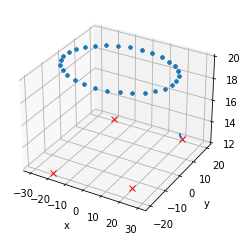

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(drone_coords[:,0], drone_coords[:,1], drone_coords[:,2],'.')
ax.plot3D(cam_poses[:,0], cam_poses[:,1], cam_poses[:,2], 'rx')
ax.quiver(cam_poses[cam,:][0], cam_poses[cam,:][1], cam_poses[cam,:][2], vec[0], vec[1], vec[2])
ax.set_xlabel('x')
ax.set_ylabel('y')

## Range finding
Know target's size and estimate distance to the camera.

IRIS dimension: 550 mm x 550 mm x 110 mm

In [48]:
dist_true

22.11334438749598

In [ ]:
# suppose the bounding box is 40x40 pixels
dimension = np.array([550, 550, 110])
box_size = np.array([40,40])
